Import Libararies and Load the Dataset

In [58]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

# load dataset
dataframe = pandas.read_csv("../data/heart_disease_dataset_UCI.csv")


Visualize the data

In [59]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


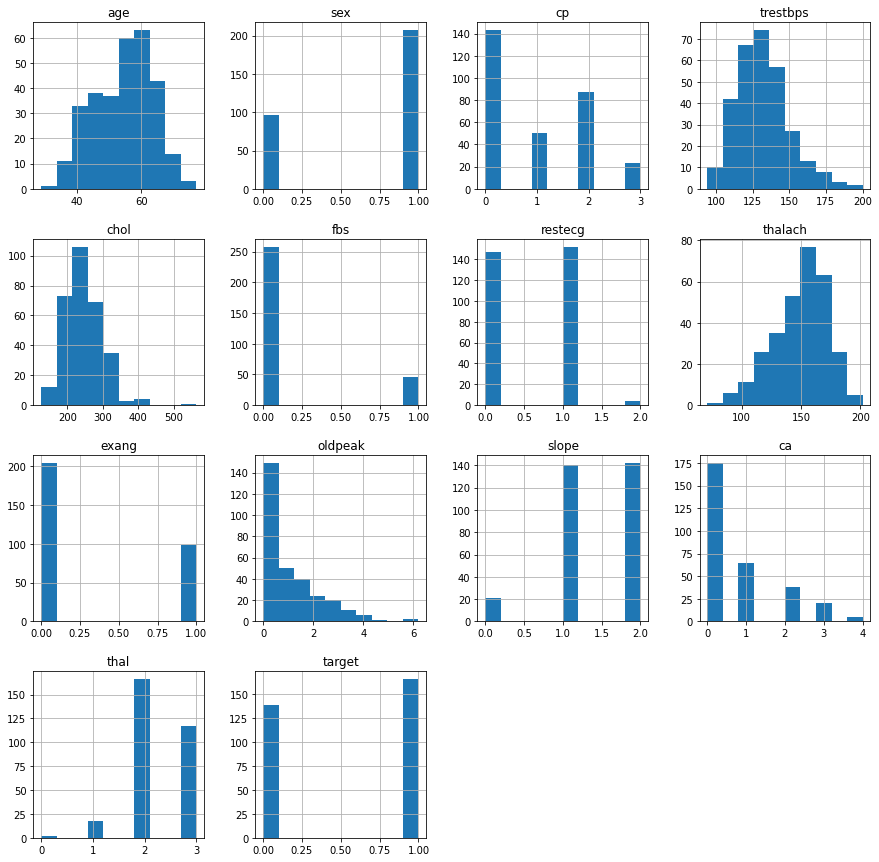

In [60]:
dataframe.hist(figsize=(15,15));

Preprocess the Data

In [61]:
columns_to_scale = ['age','trestbps','chol','thalach','oldpeak']
#Normalize and update in place
dataframe[columns_to_scale] = StandardScaler().fit_transform(dataframe[columns_to_scale])

Segregate Data

In [62]:
#Split the independent and dependent variables
X = dataframe.iloc[:,0:13]
Y = dataframe.iloc[:,13]
trainX,testX,trainY,testY = model_selection.train_test_split(X,Y,test_size=0.25,random_state=979551)

Apply Logistic regression

In [63]:
model_l1 = LogisticRegression('l1', C=7.92, solver='liblinear')
lr_l1 = model_l1.fit(trainX,trainY)
pred_l1 = lr_l1.predict(testX)

model_l2 = LogisticRegression('l2', C=0.6, solver='liblinear')
lr_l2 = model_l2.fit(trainX,trainY)
pred_l2 = lr_l2.predict(testX)

Extract Stats/Results

In [64]:
conf_mat_l1=confusion_matrix(testY,pred_l1)
conf_mat_l2=confusion_matrix(testY,pred_l2)

In [65]:
print(lr_l1.score(testX, testY))
print(lr_l2.score(testX, testY))

0.8289473684210527
0.8421052631578947


<AxesSubplot:>

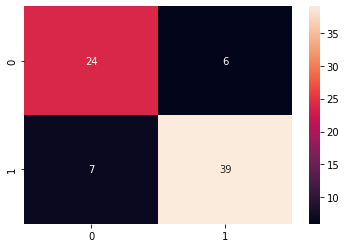

In [66]:
sns.heatmap(conf_mat_l1,annot=True)

<AxesSubplot:>

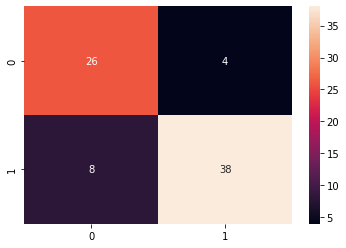

In [67]:
sns.heatmap(conf_mat_l2,annot=True)

In [68]:
from sklearn.metrics import classification_report
print(classification_report(testY,pred_l1))
print(classification_report(testY,pred_l2))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79        30
           1       0.87      0.85      0.86        46

    accuracy                           0.83        76
   macro avg       0.82      0.82      0.82        76
weighted avg       0.83      0.83      0.83        76

              precision    recall  f1-score   support

           0       0.76      0.87      0.81        30
           1       0.90      0.83      0.86        46

    accuracy                           0.84        76
   macro avg       0.83      0.85      0.84        76
weighted avg       0.85      0.84      0.84        76



Implementation for Logistic Regression with gradient descent

In [69]:
# helper function to add a column of 1s to a matrix
def addones(X):
    return np.append(X,np.ones((X.shape[0],1)),axis=1)

# helper function to calculate sigmoid value
def sigmoid(z):
    return 1/(1+np.exp(-z))

# Calculate gradient for current iteration
def calc_gradient(X, Y , lam, inter_weight, penalty_type):
    weighted_score = np.dot(X, inter_weight)
    Y_pred = sigmoid(weighted_score)

    if (penalty_type == 'l1'):
        return (np.dot(X.T, (Y_pred - Y)) - (lam * np.sign(inter_weight)))
    elif (penalty_type == 'l2'):
        return (np.dot(X.T, (Y_pred - Y)) - (2 * lam  * inter_weight))
    else:
        return np.dot(X.T, (Y_pred - Y))

# function to learn weights via gradient descent using logistic regression
def learnlr(X, Y, lam=0.0, penalty_type=None, num_iter=100):
    # Calculate initial weight vector with linear least square solution 
    Y_min_one_plus_one = np.where(Y == 0, -1, 1)
    X_with_ones = addones(X)
    init_weight = np.linalg.pinv(X_with_ones.T @ X_with_ones) @ X_with_ones.T @ Y_min_one_plus_one
    final_w = init_weight

    # Calculate gradient in given iterations using derivative of cross entropy cost
    for i in range(num_iter):
        gradient = calc_gradient(X_with_ones, Y, lam, final_w, penalty_type)
        final_w -= 0.5 * gradient

    return final_w

In [70]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import warnings

# Filter out overflow warnings in sigmoid function
warnings.filterwarnings('ignore')

In [71]:
# helper function to calculate accuracy score for cross validation
def accuracy_cv(X,Y,w):
    Y_hat = np.round(sigmoid(np.dot(addones(X), w)))
    return accuracy_score(Y_hat, Y)


def run_lr_cross_valid(penalty=None):
    fig,axs = plt.subplots(1,2, figsize=(10,5))

    lams = np.logspace(-1,3,50)
    num_folds = 10
    train_acc = np.zeros(len(lams))
    valid_acc = np.zeros(len(lams))

    # get splitting object
    cv = KFold(n_splits=num_folds, random_state=1, shuffle=True)
    
    for i,l in enumerate(lams):
        train_acc_for_l = np.zeros(num_folds)
        valid_acc_for_l = np.zeros(num_folds)

        # Run cross validation on given number of folds (splits)
        for fold_iter, (subtrain_idx, valid_idx) in enumerate(cv.split(trainX, trainY)):
            subtrainX = trainX.iloc[subtrain_idx]
            subtrainY = trainY.iloc[subtrain_idx]
            validX = trainX.iloc[valid_idx]
            validY = trainY.iloc[valid_idx]
            w_for_l = learnlr(subtrainX,subtrainY,l, penalty_type=penalty)
            train_acc_for_l[fold_iter] = accuracy_cv(subtrainX,subtrainY,w_for_l)
            valid_acc_for_l[fold_iter] = accuracy_cv(validX,validY,w_for_l)

        train_acc[i] = np.mean(train_acc_for_l)
        valid_acc[i] = np.mean(valid_acc_for_l)

    for ax,e in zip(axs,[train_acc,valid_acc]):
        ax.semilogx(lams,e)
    for i,ax in enumerate(axs):
        ax.set_title('Training Accuracy' if i==0 else 'Validation Accuracy')
        ax.set_xlabel('Regularization Strength')
        ax.set_ylabel('Accuracy')

    besti = np.argmax(valid_acc)
    bestw = learnlr(trainX,trainY,lams[besti], penalty_type=penalty)
    print('Regularization:', penalty, 'Best lambda value:',lams[besti], 'Accuracy score:', accuracy_cv(testX, testY, bestw))

    return bestw, lams[besti]

Regularization: l1 Best lambda value: 9.102981779915218 Accuracy score: 0.8552631578947368


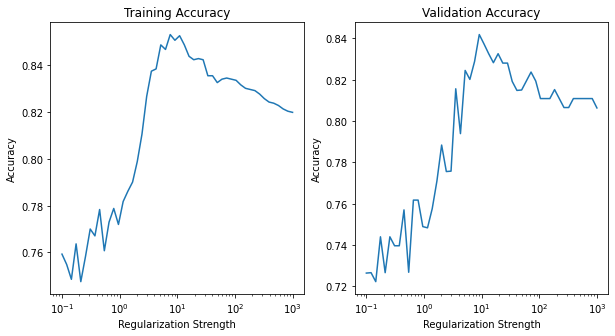

In [72]:
bestw_l1, best_lam_l1 = run_lr_cross_valid(penalty='l1')

Regularization: l2 Best lambda value: 184.20699693267144 Accuracy score: 0.8421052631578947


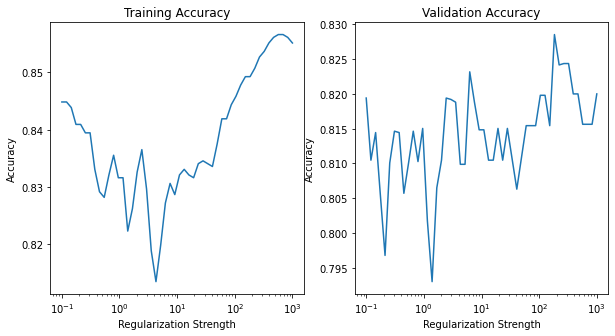

In [73]:
bestw_l2, best_lam_l2 = run_lr_cross_valid(penalty='l2')

In [74]:
# Get the classifier and predicted Y
classifier_l1 = sigmoid(np.dot(addones(testX), bestw_l1))
Y_pred_own_lr_l1 = np.round(classifier_l1)
classifier_l2 = sigmoid(np.dot(addones(testX), bestw_l2))
Y_pred_own_lr_l2 = np.round(classifier_l2)

In [75]:
conf_mat_own_l1=confusion_matrix(testY,Y_pred_own_lr_l1)
conf_mat_own_l2=confusion_matrix(testY,Y_pred_own_lr_l2)

<AxesSubplot:>

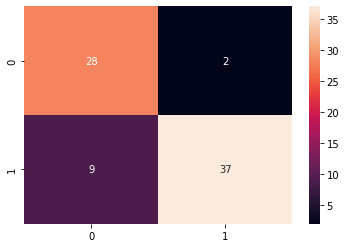

In [76]:
sns.heatmap(conf_mat_own_l1,annot=True)

<AxesSubplot:>

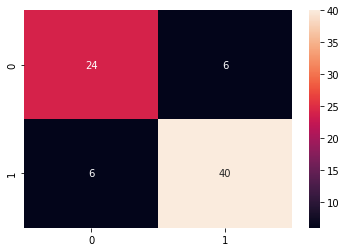

In [77]:
sns.heatmap(conf_mat_own_l2,annot=True)